In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import os
import pathlib
from keras.applications import densenet
import PIL
import scipy

In [5]:
#이미 데이터 증강이 완료된 casting_Data train /test 디렉토리에서 데이터를 전처리 및 파이프라인 구성

#image data genetator
image_data_gen = image.ImageDataGenerator(rescale = 1/255., validation_split= 0.2)
#1.train data
train_data = image_data_gen.flow_from_directory(
    directory="train/data/directory" , 
    target_size=(224,224) , batch_size=32, class_mode = 'binary', subset = 'training')

Found 5307 images belonging to 2 classes.


In [9]:
#2.val data
val_data = image_data_gen.flow_from_directory(
    directory="train/data/directory(subset = validation)" , 
    target_size=(224,224) , batch_size=32, class_mode = 'binary', subset = 'validation')

Found 1326 images belonging to 2 classes.


In [12]:
#3.test data

test_gen = image.ImageDataGenerator(rescale = 1/255.)
test_data = test_gen.flow_from_directory(
    directory='test/data/directory',
    target_size = (224,224), batch_size = 32, class_mode = 'binary')

Found 715 images belonging to 2 classes.


In [13]:
print('train:',train_data.class_indices,'\t','validation', val_data.class_indices, '\n','test:',test_data.class_indices)

train: {'def_front': 0, 'ok_front': 1} 	 validation {'def_front': 0, 'ok_front': 1} 
 test: {'def_front': 0, 'ok_front': 1}


In [6]:
input_shape = (224,224,3)
inputs = keras.Input(shape = input_shape)

In [8]:
#dense 121 모델
#weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

dense121 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights = 'imagenet',
    input_tensor= inputs,
    pooling='max',
    classes=2
)
#densenet 합성곱층 가중치 동결
dense121.trainable = False

#밀집분류기를 합성곱 기반층에 추가
x = keras.applications.densenet.preprocess_input(inputs)
x = dense121(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

Metal device set to: Apple M1


2023-02-23 22:08:52.948763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 22:08:52.948889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
#이진분류 / adam / 정확도 추정
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0     

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_dense121.keras', save_best_only = True, monitor = 'val_loss')

history = model.fit(train_data, epochs = 50, validation_data = val_data, callbacks = checkpoint)

Epoch 1/50


2023-02-23 22:08:54.857507: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-23 22:08:57.022334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.6071

2023-02-23 22:09:50.722239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 70s 405ms/step - loss: 0.6700 - accuracy: 0.6071 - val_loss: 0.5952 - val_accuracy: 0.6621
Epoch 2/50
166/166 [==============================] - 64s 388ms/step - loss: 0.5736 - accuracy: 0.6874 - val_loss: 0.5232 - val_accuracy: 0.7406
Epoch 3/50
166/166 [==============================] - 69s 417ms/step - loss: 0.5111 - accuracy: 0.7449 - val_loss: 0.4526 - val_accuracy: 0.7805
Epoch 4/50
166/166 [==============================] - 66s 397ms/step - loss: 0.4397 - accuracy: 0.8003 - val_loss: 0.4069 - val_accuracy: 0.8401
Epoch 5/50
166/166 [==============================] - 66s 398ms/step - loss: 0.3946 - accuracy: 0.8216 - val_loss: 0.3558 - val_accuracy: 0.8650
Epoch 6/50
166/166 [==============================] - 69s 414ms/step - loss: 0.3564 - accuracy: 0.8506 - val_loss: 0.3353 - val_accuracy: 0.8499
Epoch 7/50
166/166 [==============================] - 67s 402ms/step - loss: 0.3279 - accuracy: 0.8592 - val_loss: 0.2944 - val_accuracy: 0.8

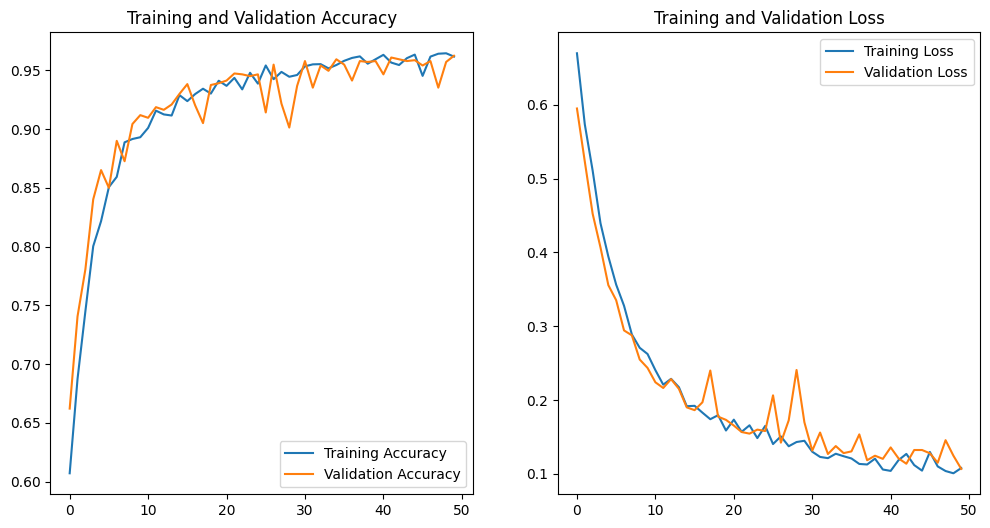

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
test_model = keras.models.load_model('best_dense121.keras')
test_loss, test_acc = test_model.evaluate(test_data)
print(f'test accuracy = {test_acc:.3f}')

2023-02-23 23:24:18.499572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 10s 365ms/step - loss: 0.0942 - accuracy: 0.9678
test accuracy = 0.968


In [16]:



#densenet169
dense169 = tf.keras.applications.DenseNet169(
    include_top=False,
    weights = 'imagenet',
    input_tensor= inputs,
    pooling='max',
    classes=2
)
#densenet 합성곱층 가중치 동결
dense169.trainable = False


#밀집분류기를 합성곱 기반층에 추가
x = keras.applications.densenet.preprocess_input(inputs)
x = dense169(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

51877672/51877672 [==============================] - 2s 0us/step


In [17]:
#이진분류 / adam / 정확도 추정
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                           

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_dense169.keras', save_best_only = True, monitor = 'val_loss')

history = model.fit(train_data, epochs = 50, validation_data = val_data, callbacks = checkpoint )

Epoch 1/50


2023-02-23 23:24:54.765127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.6963

2023-02-23 23:26:03.329108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 93s 520ms/step - loss: 0.5838 - accuracy: 0.6963 - val_loss: 0.4234 - val_accuracy: 0.8175
Epoch 2/50
166/166 [==============================] - 79s 478ms/step - loss: 0.3852 - accuracy: 0.8304 - val_loss: 0.3524 - val_accuracy: 0.8484
Epoch 3/50
166/166 [==============================] - 79s 475ms/step - loss: 0.3030 - accuracy: 0.8741 - val_loss: 0.2649 - val_accuracy: 0.9035
Epoch 4/50
166/166 [==============================] - 83s 501ms/step - loss: 0.2309 - accuracy: 0.9129 - val_loss: 0.2065 - val_accuracy: 0.9306
Epoch 5/50
166/166 [==============================] - 82s 493ms/step - loss: 0.2068 - accuracy: 0.9224 - val_loss: 0.1750 - val_accuracy: 0.9457
Epoch 6/50
166/166 [==============================] - 82s 495ms/step - loss: 0.1621 - accuracy: 0.9437 - val_loss: 0.1555 - val_accuracy: 0.9449
Epoch 7/50
166/166 [==============================] - 82s 495ms/step - loss: 0.1533 - accuracy: 0.9442 - val_loss: 0.1454 - val_accuracy: 0.9

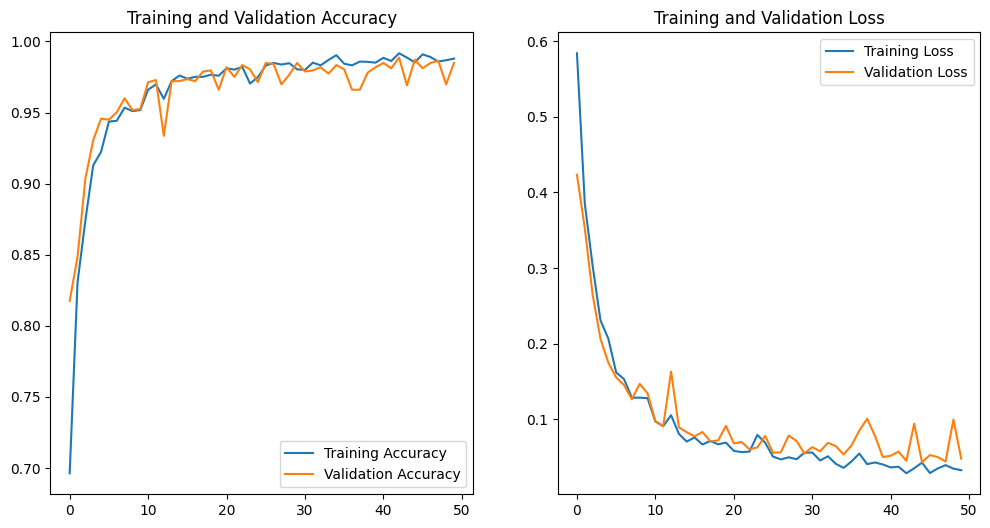

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')

plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
test_model = keras.models.load_model('best_dense169.keras')
test_loss, test_acc = test_model.evaluate(test_data)
print(f'test accuracy = {test_acc:.3f}')

2023-02-24 01:28:50.762945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 15s 514ms/step - loss: 0.0259 - accuracy: 0.9916
test accuracy = 0.992


In [7]:


#dense 201

dense201 = tf.keras.applications.DenseNet201(
    include_top=False,
    weights = 'imagenet',
    input_tensor= inputs,
    pooling='max',
    classes=2
)
#densenet 합성곱층 가중치 동결
dense201.trainable = False


#밀집분류기를 합성곱 기반층에 추가
x = keras.applications.densenet.preprocess_input(inputs)
x = dense201(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

Metal device set to: Apple M1


2023-03-02 15:21:00.587594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 15:21:00.587823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
#이진분류 / adam / 정확도 추정
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0     

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_dense201.keras', save_best_only = True, monitor = 'val_loss')

history = model.fit(train_data, epochs = 20, validation_data = val_data, callbacks = checkpoint )

Epoch 1/20


2023-03-02 15:21:16.591153: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-02 15:21:20.250926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.7059

2023-03-02 15:22:57.277319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 128s 737ms/step - loss: 0.5821 - accuracy: 0.7059 - val_loss: 0.4233 - val_accuracy: 0.8281
Epoch 2/20
166/166 [==============================] - 115s 692ms/step - loss: 0.3998 - accuracy: 0.8202 - val_loss: 0.3579 - val_accuracy: 0.8778
Epoch 3/20
166/166 [==============================] - 116s 698ms/step - loss: 0.3238 - accuracy: 0.8626 - val_loss: 0.3066 - val_accuracy: 0.8741
Epoch 4/20
166/166 [==============================] - 116s 701ms/step - loss: 0.2864 - accuracy: 0.8754 - val_loss: 0.2484 - val_accuracy: 0.9133
Epoch 5/20
166/166 [==============================] - 117s 704ms/step - loss: 0.2404 - accuracy: 0.9056 - val_loss: 0.2740 - val_accuracy: 0.8590
Epoch 6/20
166/166 [==============================] - 119s 715ms/step - loss: 0.2521 - accuracy: 0.8988 - val_loss: 0.2536 - val_accuracy: 0.8816
Epoch 7/20
166/166 [==============================] - 119s 718ms/step - loss: 0.2018 - accuracy: 0.9199 - val_loss: 0.2046 - val_accura

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
test_model = keras.models.load_model('best_dense201_2.keras')
test_loss, test_acc = test_model.evaluate(test_data)
print(f'test accuracy = {test_acc:.3f}')

2023-03-02 16:02:36.372706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 22s 778ms/step - loss: 0.0899 - accuracy: 0.9720
test accuracy = 0.972
